In [1]:
%cd /kaggle/input/chemcancer-v2/src/
%mkdir /kaggle/working/Deep_Learning_metrics/
%mkdir /kaggle/working/During_train/
%mkdir /kaggle/working/CV_CNN_models
%mkdir /kaggle/working/CV_CNN_results
%mkdir /kaggle/working/CV_CNN_fold_data
%mkdir /kaggle/working/CV_CNN_cm

/kaggle/input/chemcancer-v2/src


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tensorflow.keras.optimizers import Adam
from data import *
from machine_learning_models import *
from deep_learning_models import *
from vision_transformer import *
from utils_dl_model import *
from utils_ml_model import print_ml_results
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
# Set the seed value.
SEED = 7
np.random.seed(SEED)

# Deep Learning parameters
DL_EPOCH = 800
DL_BATCH_SIZE = 32
DL_CNN_VERSION = 3
DL_TRANSFORMER_VISION_VERSION = 14
DL_CV_FOLD = 5

DO_DL = True
CV_DL = True
OPT_DL = False

DO_CNN = True
DO_TRANSFORMER_VISION = False
DO_ML = False

# Percentage of test set out of the dataset.
TEST_SET = 0.2

# Percentage of validation set out of the training dataset.
VAL_SET = 0.2

# Folder path associated with deep learning models
dl_models_folder = "../Deep_Learning_models/"
dl_metrics_folder = "../Deep_Learning_metrics/"
dl_weights_folder = "../Deep_Learning_weights/"
dl_cv_models_folder = "../Deep_Learning_CV/"
dl_cv_results_folder = "../Deep_Learning_CV_results/"

# Folder path associated with machine learning models
ml_models_folder = "../Machine_Learning_models/"
ml_models_results_folder = "../Machine_Learning_models_results/"

# Model names (Saved in h5 format)
cnn_model_name = f"cnn_v{DL_CNN_VERSION}_{DL_BATCH_SIZE}_{DL_EPOCH}_seed_{SEED}.h5"
transformer_vis_model_name = f"transformer_vision_v{DL_TRANSFORMER_VISION_VERSION}_{DL_BATCH_SIZE}_{DL_EPOCH}_seed_{SEED}.h5"

# Metric filenames
cnn_metrics_filename = f"metrics_{cnn_model_name}.json"
transformer_vis_metrics_filename = f"metrics_{transformer_vis_model_name}.json"

# Weight filenames
cnn_weights_filename = f"weights_{cnn_model_name}.json"
transformer_vis_weights_filename = f"weights_{transformer_vis_model_name}.json"


# Deep Learning models path
if DO_CNN:
    dl_model_path = os.path.join(
        dl_models_folder, cnn_model_name)
elif DO_TRANSFORMER_VISION:
    dl_model_path = os.path.join(
        dl_models_folder, transformer_vis_model_name)


# Deep Learning metrics path
if DO_CNN:
    dl_metrics_path = os.path.join(
        dl_metrics_folder, cnn_metrics_filename)
elif DO_TRANSFORMER_VISION:
    dl_metrics_path = os.path.join(
        dl_metrics_folder, transformer_vis_metrics_filename)


# Deep Learning weights path
if DO_CNN:
    dl_weights_path = os.path.join(
        dl_weights_folder, cnn_weights_filename)

elif DO_TRANSFORMER_VISION:
    dl_weights_path = os.path.join(
        dl_weights_folder, transformer_vis_weights_filename)

In [4]:
def cnn_model_3(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [5]:
import pickle

def perform_cnn_cv(X, y, learning_rate, dropout_rate, l2_regularizer, 
                             n_splits=5, epochs=100, batch_size=32, cnn_version = 1, val_set = 0.2,
                             do_opt = False,models_folder = "models", results_folder = "results"):
    
    if not os.path.exists(models_folder):
        os.makedirs(models_folder)

    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
    accuracies = []
    test_losses = []
    test_accuracies = []
    
    # Initialize lists to store precision, recall, and F1 scores
    precisions = []
    recalls = []
    f1_scores = []
    
    # Initialize lists to store losses and accuracies for each epoch
    mean_training_losses = []
    mean_training_accuracies = []
    mean_val_losses = []   
    mean_val_accuracies = []
    
    # Initialize lists to store losses and accuracies for each epoch
    all_training_losses = []
    all_training_accuracies = []
    all_val_losses = []   
    all_val_accuracies = []
    
    fold = 1
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed_value)
    
    for train_index, test_index in skf.split(X, y):
        # Split the data into training and validation sets
        print("=" * 40)
        print(f"Fold: {fold}")
        print("Splitting the data")
        X_train_full, X_test = X[train_index], X[test_index]
        y_train_full, y_test = y[train_index], y[test_index]
        
        # Standardize the data
        print("Standardizing the data")
        X_train_full, X_test = standardize_data(X_train_full, X_test)
        
        # Reshape the data
        print("Reshaping the data for deep learning models")
        X_train_full, X_test = reshape_data(X_train_full, X_test)
        
        # Input shape and number of classes for the model
        input_shape = (X_train_full.shape[1], 1)
        num_classes = len(np.unique(y))
        
        X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size = 0.2, random_state = seed_value, stratify = y_train_full)
        
        try:
            if do_opt:
                model = cnn_model_3(input_shape, num_classes)
#                 model = cnn_model_3_opt(input_shape, num_classes, learning_rate, dropout_rate, l2_regularizer)
            else:
                model = cnn_model_3(input_shape, num_classes)
            if model is not None:
                print("Building the model 3 with the following hyperparameters:")
                print(f"Learning rate: {learning_rate}")
                print(f"Dropout rate: {dropout_rate}") 
                print(f"L2 Regularizer: {l2_regularizer}")
                print(f"Number of epochs: {epochs}")
                print(f"Batch size: {batch_size}")
                # model.summary()
            else:
                print("Failed to build the CNN model.")
        except Exception as e:
            print(f"Error while building the CNN model: {e}")
        
        print("Saving the data")
        fold_data = {

            'X_train': X_train,
            'X_val': X_val,
            'X_test': X_test,
            'y_train': y_train,
            'y_val': y_val,
            'y_test': y_test
        }

        with open(f"/kaggle/working/CV_CNN_fold_data/fold_{fold}_data.pkl", 'wb') as f:
            pickle.dump(fold_data, f)
        
        
        print("Training the model")
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))
        y_pred = np.argmax(model.predict(X_test), axis=-1)
        accuracy = accuracy_score(y_test, y_pred)
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        
            # Calculate precision, recall, and F1 score
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')

        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        # Append the scores to the lists
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        
        all_training_losses.extend(history.history['loss'])
        all_training_accuracies.extend(history.history['accuracy'])
        all_val_losses.extend(history.history['val_loss'])
        all_val_accuracies.extend(history.history['val_accuracy'])
        
        # Append the losses and accuracies for each epoch to the respective lists
        for epoch in range(epochs):
            if fold == 1:
                # For the first fold, initialize the lists with the first fold's values
                mean_training_losses.append(history.history['loss'][epoch])
                mean_training_accuracies.append(history.history['accuracy'][epoch])
                mean_val_losses.append(history.history['val_loss'][epoch])
                mean_val_accuracies.append(history.history['val_accuracy'][epoch])
            else:
                # For subsequent folds, add the fold's values to the running sum
                mean_training_losses[epoch] += history.history['loss'][epoch]
                mean_training_accuracies[epoch] += history.history['accuracy'][epoch]
                mean_val_losses[epoch] += history.history['val_loss'][epoch]
                mean_val_accuracies[epoch] += history.history['val_accuracy'][epoch]

        # Save the model
        if do_opt:
            model_filename = f"cnn_v{cnn_version}_opt_{batch_size}_{epochs}_seed{seed_value}.h5"
        else:
            model_filename = f"cnn_v{cnn_version}_{batch_size}_{epochs}_seed{seed_value}.h5"
        model_filepath = os.path.join(models_folder, f"fold_{fold}_split_{n_splits}_{model_filename}")
        model.save(model_filepath)

        # Save the results as a JSON file
        if do_opt:
            results_filename = f"cnn_v{cnn_version}_opt_{batch_size}_{epochs}_seed{seed_value}.json"
        else:
            results_filename = f"cnn_v{cnn_version}_{batch_size}_{epochs}_seed{seed_value}.json"
        results_filepath = os.path.join(results_folder, f"fold_{fold}_split_{n_splits}_{results_filename}")

        results = {
            "fold": fold,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_scores": f1_scores,
            "test_loss": test_loss,
            "test_accuracy": test_accuracy,
            "training_loss": history.history['loss'],
            "training_accuracy": history.history['accuracy'],
            "validation_loss": history.history['val_loss'],
            "validation_accuracy": history.history['val_accuracy'],
        }

        with open(results_filepath, "w") as results_file:
            json.dump(results, results_file, indent=4)
        
        # Append the results to the lists
        accuracies.append(accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        print(f"Fold {fold}, Accuracy: {accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
        print("=" * 40)
        fold += 1

    # At the end, divide the sums by the number of folds to get the mean
    mean_training_losses = [loss / n_splits for loss in mean_training_losses]
    mean_training_accuracies = [acc / n_splits for acc in mean_training_accuracies]
    mean_val_losses = [loss / n_splits for loss in mean_val_losses]
    mean_val_accuracies = [acc / n_splits for acc in mean_val_accuracies]
    # Convert lists to numpy arrays for easier calculation of mean and standard deviation
    mean_accuracy = np.mean(accuracies)
    mean_test_loss = np.mean(test_losses)
    mean_test_accuracy = np.mean(test_accuracies)
    
    mean_training_loss = np.mean(all_training_losses)
    std_training_loss = np.std(all_training_losses)
    mean_training_accuracy = np.mean(all_training_accuracies)
    std_training_accuracy = np.std(all_training_accuracies)

    mean_val_loss = np.mean(all_val_losses)
    std_val_loss = np.std(all_val_losses)
    mean_val_accuracy = np.mean(all_val_accuracies)
    std_val_accuracy = np.std(all_val_accuracies)

    # Calculate standard deviations
    std_accuracy = np.std(accuracies)
    std_test_loss = np.std(test_losses)
    std_test_accuracy = np.std(test_accuracies)

    std_training_loss = np.std(mean_training_losses)
    std_training_accuracy = np.std(mean_training_accuracies)
    std_val_loss = np.std(mean_val_losses)
    std_val_accuracy = np.std(mean_val_accuracies)

    precisions = np.array(precisions)
    recalls = np.array(recalls)
    f1_scores = np.array(f1_scores)

      
    print(f"test losses: {test_losses}")
    print(f"test accuracy: {test_accuracies}")
    
    print("*" * 40)
    print(f"Mean training loss over {n_splits}-fold cross-validation: {mean_training_loss:.4f}")
    print(f"Mean training accuracy over {n_splits}-fold cross-validation: {mean_training_accuracy:.4f}")
    print(f"Mean validation loss over {n_splits}-fold cross-validation: {mean_val_loss:.4f}")
    print(f"Mean validation accuracy over {n_splits}-fold cross-validation: {mean_val_accuracy:.4f}")
    print("*" * 40)
    print(f"Mean accuracy over stratified {n_splits}-fold cross-validation: {mean_accuracy:.4f}")
    print(f"Mean test loss over stratified {n_splits}-fold cross-validation: {mean_test_loss:.4f}")
    print(f"Mean test accuracy over stratified {n_splits}-fold cross-validation: {mean_test_accuracy:.4f}")
    
    print("*" * 40)
    print(f"Standard deviation of training loss over {n_splits}-fold cross-validation: {std_training_loss:.4f}")
    print(f"Standard deviation of training accuracy over {n_splits}-fold cross-validation: {std_training_accuracy:.4f}")
    print(f"Standard deviation of validation loss over {n_splits}-fold cross-validation: {std_val_loss:.4f}")
    print(f"Standard deviation of validation accuracy over {n_splits}-fold cross-validation: {std_val_accuracy:.4f}")
        
    print("*" * 40)
    print(f"Standard deviation of accuracy over stratified {n_splits}-fold cross-validation: {std_accuracy:.4f}")
    print(f"Standard deviation of test loss over stratified {n_splits}-fold cross-validation: {std_test_loss:.4f}")
    print(f"Standard deviation of test accuracy over stratified {n_splits}-fold cross-validation: {std_test_accuracy:.4f}")
    print("*" * 40)
    
    # Calculate and print the mean and standard deviation of precision, recall, and F1 score
    print(f"Mean precision over stratified {n_splits}-fold cross-validation: {np.mean(precisions):.4f}")
    print(f"Standard deviation of precision over stratified {n_splits}-fold cross-validation: {np.std(precisions):.4f}")
    print(f"Mean recall over stratified {n_splits}-fold cross-validation: {np.mean(recalls):.4f}")
    print(f"Standard deviation of recall over stratified {n_splits}-fold cross-validation: {np.std(recalls):.4f}")
    print(f"Mean F1 score over stratified {n_splits}-fold cross-validation: {np.mean(f1_scores):.4f}")
    print(f"Standard deviation of F1 score over stratified {n_splits}-fold cross-validation: {np.std(f1_scores):.4f}")

    
# Define the directory where the JSON files are stored

    fig, axes = plt.subplots(2, n_splits, figsize=(20, 10))

    for fold in range(1, n_splits+1):
        # Load the JSON file for this fold
        if do_opt:
            cnn_filename = f"cnn_v{cnn_version}_opt_{batch_size}_{epochs}_seed{seed_value}.json"
        else:
            cnn_filename = f"cnn_v{cnn_version}_{batch_size}_{epochs}_seed{seed_value}.json"
        results_filename = f"fold_{fold}_split_{n_splits}_{cnn_filename}"
        
        results_filepath = os.path.join(results_folder, results_filename)
        
        with open(results_filepath, "r") as results_file:
            results = json.load(results_file)
        
        # Plot training and validation loss
        axes[0, fold-1].plot(results["training_loss"], label='Train')
        axes[0, fold-1].plot(results["validation_loss"], label='Validation')
        axes[0, fold-1].set_title(f'Fold {fold} Loss')
        axes[0, fold-1].set_xlabel('Epochs')
        axes[0, fold-1].set_ylabel('Loss')
        axes[0, fold-1].legend()

        # Plot training and validation accuracy
        axes[1, fold-1].plot(results["training_accuracy"], label='Train')
        axes[1, fold-1].plot(results["validation_accuracy"], label='Validation')
        axes[1, fold-1].set_title(f'Fold {fold} Accuracy')
        axes[1, fold-1].set_xlabel('Epochs')
        axes[1, fold-1].set_ylabel('Accuracy')
        axes[1, fold-1].legend()

    plt.tight_layout()
    plt.show()

    return mean_val_accuracies  

Load the data
Data shape : (2373, 274)
Extract the feature and target data
X shaped: (2373, 270)
y shaped: (2373,)
Apply filters and background substraction to the features dataset
Fold: 1
Splitting the data
Standardizing the data
Reshaping the data for deep learning models
Building the model 3 with the following hyperparameters:
Learning rate: 1.4286522423518213e-05
Dropout rate: 0.4
L2 Regularizer: 0.000417822262290105
Number of epochs: 800
Batch size: 32
Saving the data
Training the model
Epoch 1/800
48/48 [==============================] - 11s 15ms/step - loss: 2.2683 - accuracy: 0.3478 - val_loss: 1.3659 - val_accuracy: 0.3158
Epoch 2/800
48/48 [==============================] - 0s 8ms/step - loss: 1.7812 - accuracy: 0.3551 - val_loss: 1.3817 - val_accuracy: 0.3158
Epoch 3/800
48/48 [==============================] - 0s 8ms/step - loss: 1.5903 - accuracy: 0.3505 - val_loss: 1.3447 - val_accuracy: 0.3474
Epoch 4/800
48/48 [==============================] - 0s 9ms/step - loss: 1.451

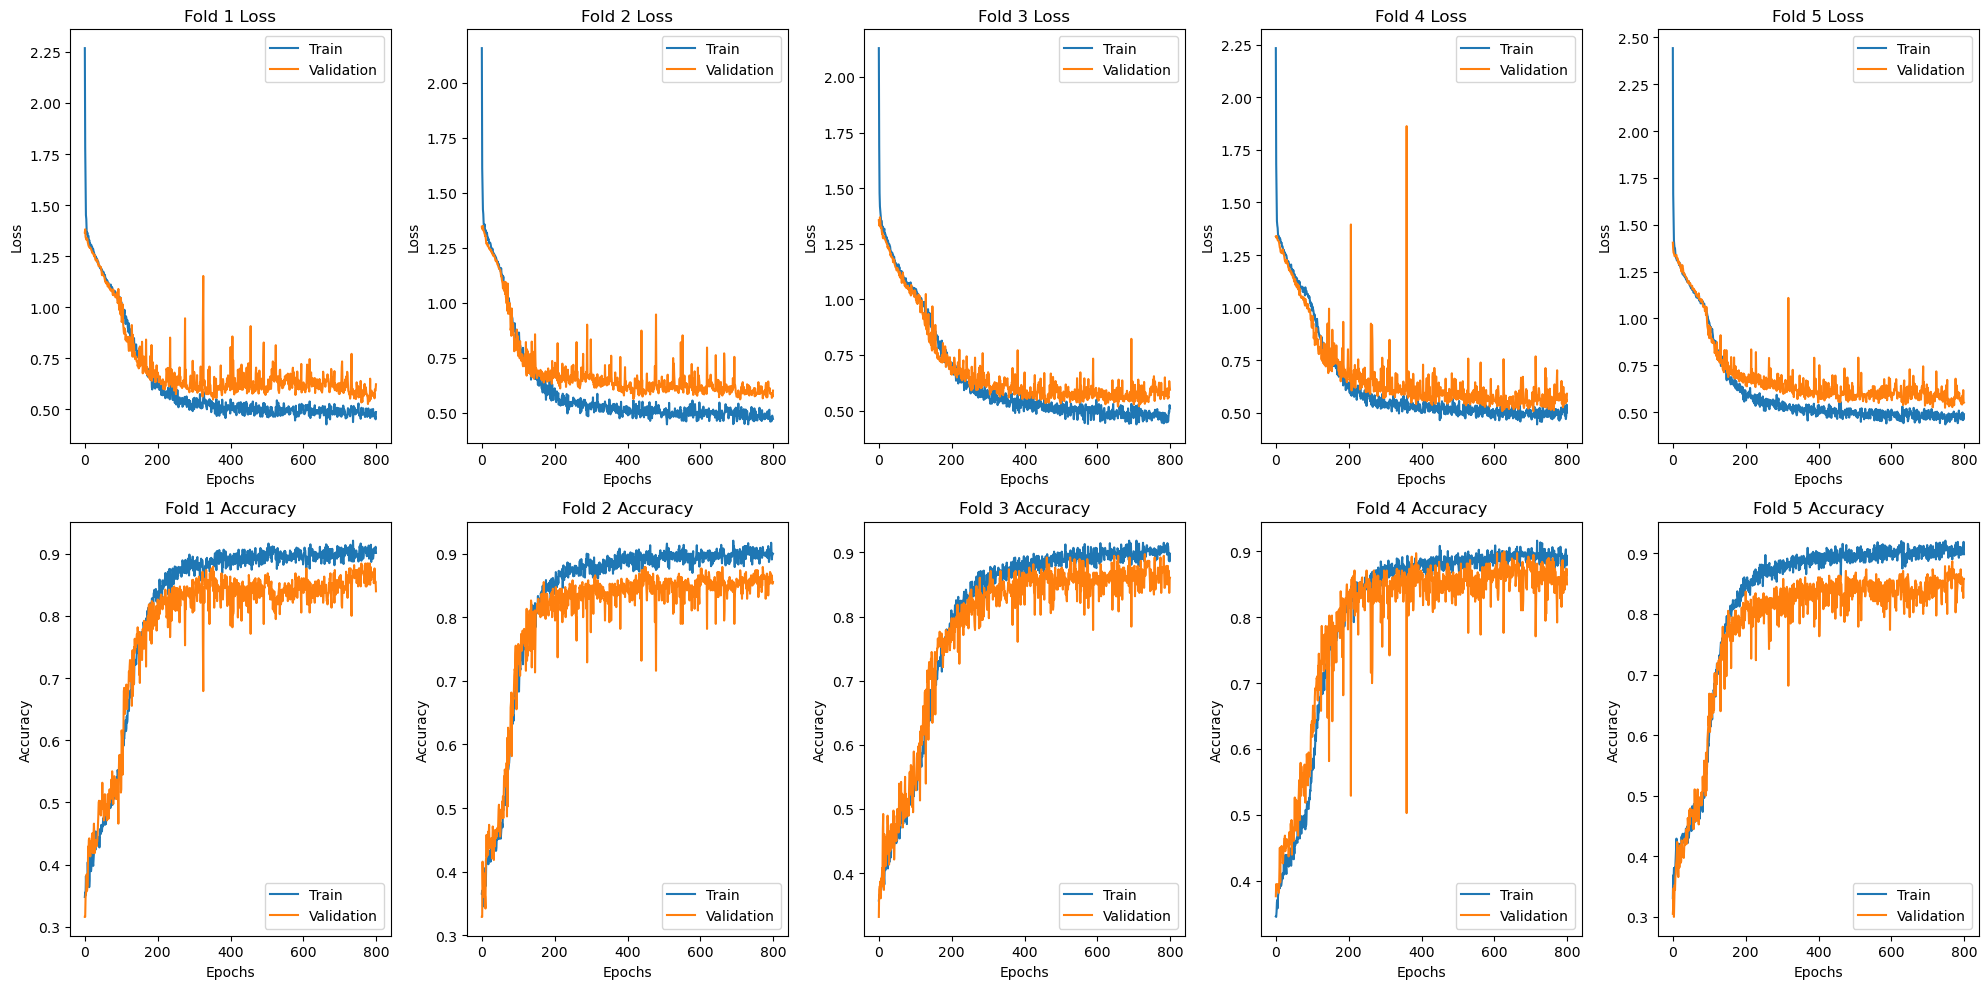

Training time: 1803.02 seconds


In [6]:
# Load the data
data_file = "../Data/HC05_HC07.csv"

if OPT_DL:
    X_filtered, y = preprocess_cv_raw_data(data_file)
    optimize_hyperparameters(X_filtered, y, 50, dl_cv_models_folder, dl_cv_results_folder)

else:
    # Train deep learning model with cross validation
    if CV_DL:
        X_filtered, y = preprocess_cv_raw_data(data_file)
    else:
        # Preprocess the raw data
        X_train, X_test, y_train, y_test = preprocess_raw_data(
            data_file, TEST_SET)

# Do Deep Learning
if DO_DL:
    dl_weights_path = "../During_train/cnn_v3-250-val_acc0.86.h5"
    if os.path.exists(dl_model_path):
        if DO_TRANSFORMER_VISION:
            model = tf.keras.models.load_model(
                dl_model_path, custom_objects={'ClassToken': ClassToken, 'TransformerBlock': TransformerBlock})
        elif DO_CNN:
            model = tf.keras.models.load_model(dl_model_path)
            print("Loaded trained model from", dl_model_path)
    elif os.path.exists(dl_weights_path):
        if DO_TRANSFORMER_VISION:
            print("hello")
            # model = create_vit(input_shape, patch_size, num_patches, num_classes,
            #                         embed_dim, num_heads, mlp_dim, num_layers, dropout_rate)
            # model.load_weights(dl_weights_path)
        elif DO_CNN:
            X_train = X_train.reshape(
                X_train.shape[0], X_train.shape[1], 1)
            X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
            input_shape = (X_train.shape[1], 1)
            num_classes = len(np.unique(y_train))
            learning_rate = 1.4286522423518213e-09
            dropout_rate = 0.2
            l2_regularizer = 0.000417822262290105
            model = cnn_model_3_opt(
                input_shape, num_classes, learning_rate, dropout_rate, l2_regularizer)
            model.load_weights(dl_weights_path)
            print("Loaded trained model weights from", dl_weights_path)
            # Evaluating the model
            print("Evaluating the CNN model... ")
            # Calculate model loss and accuracy
            test_loss, test_accuracy = model.evaluate(X_test, y_test)
            print("Test loss:", test_loss)
            print("Test accuracy:", test_accuracy)
    else:
        if CV_DL:
            # learning_rate = 3.408170980489466e-05
            # dropout_rate = 0.3
            # l2_regularizer = 0.00010124894257897855
            if DO_CNN:
                learning_rate = 1.4286522423518213e-05
                dropout_rate = 0.4
                l2_regularizer = 0.000417822262290105
                # Start the timer
                start_time = time.time()
                perform_cnn_cv(X_filtered, y, learning_rate, dropout_rate, l2_regularizer,
                                        n_splits=DL_CV_FOLD, epochs=DL_EPOCH, batch_size=DL_BATCH_SIZE, cnn_version=DL_CNN_VERSION,
                                        do_opt=True, models_folder="/kaggle/working/CV_CNN_models", results_folder= "/kaggle/working/CV_CNN_results")
                # End the timer
                end_time = time.time()
                # Calculate the elapsed time
                elapsed_time = end_time - start_time
                # Print the elapsed time
                print("Training time: {:.2f} seconds".format(elapsed_time))
            elif DO_TRANSFORMER_VISION:
                # Train and evaluate deep learning models
                print("Building Transformer model...")
                patch_size = 30
                embed_dim = 64
                num_heads = 4
                mlp_dim = 128  # patch_size * patch_size * input_shape[1]
                num_layers = 4
                dropout_rate = 0.3

                # Create the model
                perform_vit_cross_validation(X_filtered, y, patch_size, embed_dim, num_heads, mlp_dim, num_layers, dropout_rate,
                                            n_splits=DL_CV_FOLD, epochs=DL_EPOCH, batch_size=DL_BATCH_SIZE, 
                                            vit_version = DL_TRANSFORMER_VISION_VERSION, val_set = 0.2,
                                            do_opt = True, models_folder = "/kaggle/working/CV_VIT_models", results_folder = "/kaggle/working/CV_VIT_results")

        else:
            # Reshape the input data for deep learning models
            print("Reshaping the data for CNN model...")
            X_train = X_train.reshape(
                X_train.shape[0], X_train.shape[1], 1)
            X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
            input_shape = (X_train.shape[1], 1)
            num_classes = len(np.unique(y_train))

            # Splitting the training data to create a validation set
            print("Splitting the training data to create a validation set...")
            X_train, X_val, y_train, y_val = train_test_split(
                X_train, y_train, test_size=VAL_SET, random_state=SEED, stratify=y_train)

            filepath = ""

            if DO_CNN:
                # Train and evaluate deep learning models
                print("Building CNN model...")
                # model = cnn_model_3_3(input_shape, num_classes)
                # learning_rate = 3.408170980489466e-05
                # dropout_rate = 0.3
                # l2_regularizer = 0.00010124894257897855
                learning_rate = 1.4286522423518213e-05
                dropout_rate = 0.2
                l2_regularizer = 0.000417822262290105
                model = cnn_model_3_opt(
                    input_shape, num_classes, learning_rate, dropout_rate, l2_regularizer)

                filepath = '../During_train/cnn_v3-{epoch:02d}-val_acc{val_accuracy:.2f}.h5'

            elif DO_TRANSFORMER_VISION:
                # Train and evaluate deep learning models
                print("Building Transformer model...")
                # Define model parameters
                print(f"X_train shape = {X_train.shape}")
                input_shape = (X_train.shape[1], 1)  # (270,1)
                # cancer cell lines, monocytes, and T-cells
                num_classes = len(np.unique(y_train))
                patch_size = 3
                num_patches = input_shape[0] // patch_size
                embed_dim = 64
                num_heads = 4
                mlp_dim = 128  # patch_size * patch_size * input_shape[1]
                num_layers = 4
                dropout_rate = 0.3

                # Create the model
                model = create_vit(input_shape, patch_size, num_patches, num_classes,
                                   embed_dim, num_heads, mlp_dim, num_layers, dropout_rate)
                model.summary()
                # Compile the model
                model.compile(
                    optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
                filepath = '../During_train/vit_v11-{epoch:02d}-val_acc{val_accuracy:.2f}.h5'

            # Train the model
            print("Training and evaluating the model...")
            # Start the timer
            start_time = time.time()
            model_history = model.fit(X_train, y_train, batch_size=DL_BATCH_SIZE,
                                      epochs=DL_EPOCH, validation_data=(X_val, y_val), shuffle=True, callbacks=callbacks)
            # End the timer
            end_time = time.time()
            # Calculate the elapsed time
            elapsed_time = end_time - start_time
            # Print the elapsed time
            print("Training time: {:.2f} seconds".format(elapsed_time))
            # Compile the model

            # Save the deep learning model
            print("Saving model to ", dl_model_path)
            model.save(dl_model_path)

            # Save the deep learning model's weights
            print("Saving model weights to ", dl_weights_path)
            model.save_weights(dl_weights_path)

            # Evaluating the model
            print("Evaluating the CNN model... ")
            # Calculate model loss and accuracy
            test_loss, test_accuracy = model.evaluate(X_test, y_test)
            print("Test loss:", test_loss)
            print("Test accuracy:", test_accuracy)

            # Save the model's metrics
            print("Saving the model metrics to ", dl_metrics_path)
            save_dl_metrics(model_history, test_loss,
                            test_accuracy, dl_metrics_path)

            # Plot the model history
            plot_dl_history(model_history)

In [7]:
# Given the paths you provided, let's generate confusion matrices for the VIT models:
cnn_model_path = "/kaggle/working/CV_CNN_models/"
data_model_path = "/kaggle/working/CV_CNN_fold_data/"
cm_model_path = "/kaggle/working/CV_CNN_cm/"

# Lists to store metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []
confusion_matrices_cnn = []

# Loop through each fold
for fold in range(1, 6):
    # Load datasets for this fold
    with open(f"{data_model_path}fold_{fold}_data.pkl", 'rb') as f:
        fold_data = pickle.load(f)
        
    X_test = fold_data['X_test']
    y_test = fold_data['y_test']
    
    # Load the model for this fold
    model_file = f"fold_{fold}_split_5_cnn_v3_opt_32_800_seed7.h5"
    model_path = os.path.join(cnn_model_path, model_file)
    model = tf.keras.models.load_model(model_path)
    
    # Predict and evaluate
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)
    
    # Save the confusion matrix
    with open(f"{cm_model_path}cnn_cm_fold_{fold}.pkl", 'wb') as cm_file:
        pickle.dump(cm, cm_file)
    
    # Store metrics
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    confusion_matrices_cnn.append(cm)
    
    # Print metrics for this fold
    print(f"Fold {fold}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("-" * 40)

# This will give you a list of confusion matrices for each fold of the VIT models
confusion_matrices_cnn

15/15 [==============================] - 0s 2ms/step
Fold 1:
Accuracy: 0.8147
Precision: 0.8210
Recall: 0.8084
F1 Score: 0.8101
----------------------------------------
15/15 [==============================] - 0s 2ms/step
Fold 2:
Accuracy: 0.8695
Precision: 0.8756
Recall: 0.8625
F1 Score: 0.8664
----------------------------------------
15/15 [==============================] - 0s 2ms/step
Fold 3:
Accuracy: 0.8463
Precision: 0.8443
Recall: 0.8466
F1 Score: 0.8452
----------------------------------------
15/15 [==============================] - 0s 2ms/step
Fold 4:
Accuracy: 0.8291
Precision: 0.8273
Recall: 0.8302
F1 Score: 0.8276
----------------------------------------
15/15 [==============================] - 0s 2ms/step
Fold 5:
Accuracy: 0.8460
Precision: 0.8472
Recall: 0.8428
F1 Score: 0.8446
----------------------------------------


[array([[166,   8,   9],
        [ 14, 119,   9],
        [ 31,  17, 102]]),
 array([[173,   2,   8],
        [ 18, 112,  12],
        [ 14,   8, 128]]),
 array([[155,  12,  16],
        [  8, 123,  11],
        [ 13,  13, 124]]),
 array([[150,  14,  19],
        [  6, 120,  15],
        [ 10,  17, 123]]),
 array([[163,   7,  13],
        [  6, 120,  15],
        [ 24,   8, 118]])]